### Meta Estimators

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.datasets import make_classification

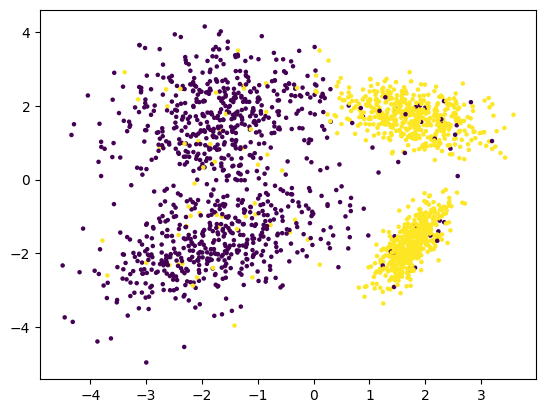

In [28]:
X, y = make_classification(
    n_samples=2000,
    n_features=2,
    n_redundant=0,
    random_state=21,
    class_sep=1.75,
    flip_y=0.1,
)
plt.scatter(X[:, 0], X[:, 1], c=y, s=5)

In [29]:
def make_plots():
    X_new = np.concatenate([
        np.random.uniform(np.min(X[:, 0]), np.max(X[:, 0]), (20000, 1)),
        np.random.uniform(np.min(X[:, 1]), np.max(X[:, 1]), (20000, 1))
    ], axis=1)
    plt.figure(figsize=(16, 4))
    plt.subplot(141)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=5)
    plt.title("original data")
    plt.subplot(142)
    plt.scatter(X_new[:, 0], X_new[:, 1], c=clf1.predict_proba(X_new)[:, 1], s=5)
    plt.title("ens1")
    plt.subplot(143)
    plt.scatter(X_new[:, 0], X_new[:, 1], c=clf2.predict_proba(X_new)[:, 1], s=5)
    plt.title("ens2")
    plt.subplot(144)
    plt.scatter(X_new[:, 0], X_new[:, 1], c=clf3.predict_proba(X_new)[:, 1], s=5)
    plt.title("ens3");

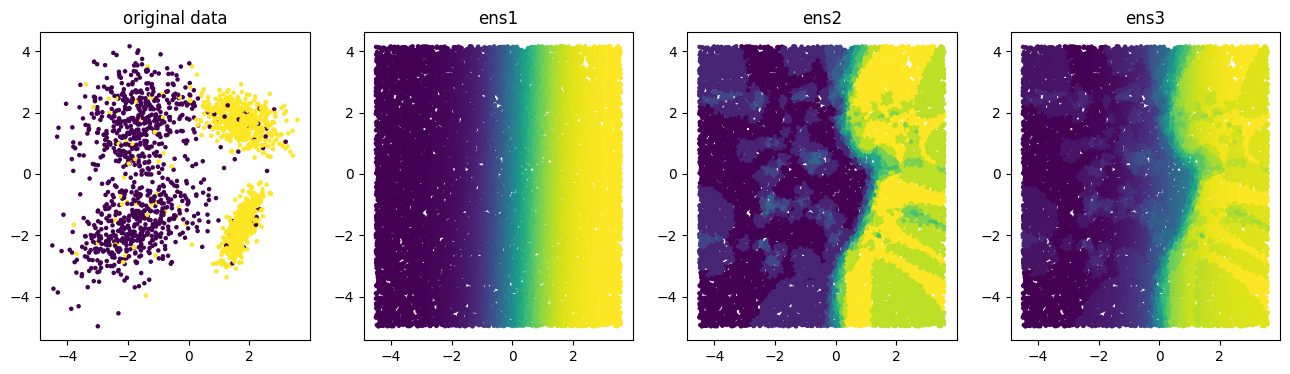

In [30]:
clf1 = LogisticRegression().fit(X, y)
clf2 = KNeighborsClassifier(n_neighbors=10).fit(X, y)
clf3 = VotingClassifier(estimators=[("clf1", clf1), ("clf2", clf2)],
                        voting="soft",
                        weights=[0.5, 0.5])
clf3.fit(X, y)

make_plots()

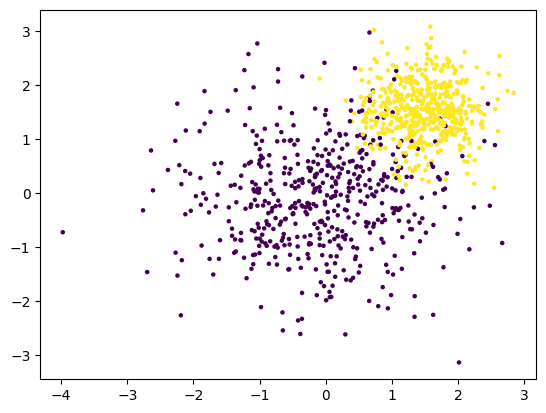

In [31]:
from sklearn.datasets import make_blobs

X, y = make_blobs(1000, centers=[(0, 0), (1.5, 1.5)], cluster_std=[1, 0.5])
plt.scatter(X[:, 0], X[:, 1], c=y, s=5)

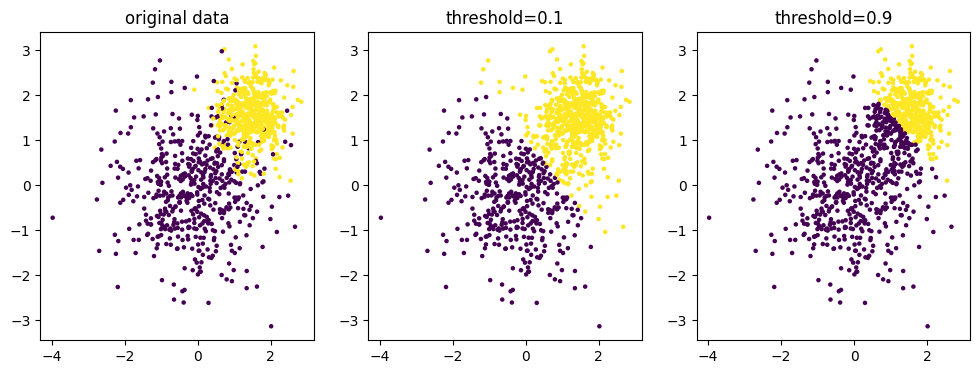

In [32]:
from sklego.meta import Thresholder

m1 = Thresholder(LogisticRegression(solver="lbfgs"), threshold=0.1).fit(X, y)
m2 = Thresholder(LogisticRegression(solver="lbfgs"), threshold=0.9).fit(X, y)

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X[:, 0], X[:, 1], c=y, s=5)
plt.title("original data")
plt.subplot(132)
plt.scatter(X[:, 0], X[:, 1], c=m1.predict(X), s=5)
plt.title("threshold=0.1")
plt.subplot(133)
plt.scatter(X[:, 0], X[:, 1], c=m2.predict(X), s=5)
plt.title("threshold=0.9");

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, make_scorer

pipe = Pipeline([
    ("model", Thresholder(LogisticRegression(solver="lbfgs"), threshold=0.1))
])

mod = GridSearchCV(estimator=pipe,
                   param_grid={"model__threshold": np.linspace(0.1, 0.9, 50)},
                   scoring={"precision": make_scorer(precision_score),
                            "recall": make_scorer(recall_score),
                            "accuracy": make_scorer(accuracy_score)},
                   refit="precision",
                   cv=5)
mod.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        Thresholder(model=LogisticRegression(),
                                                    threshold=0.1))]),
             param_grid={'model__threshold': array([0.1       , 0.11632653, 0.13265306, 0.14897959, 0.16530612,
       0.18163265, 0.19795918, 0.21428571, 0.23061224, 0.24693878,
       0.26326531, 0.27959184, 0.29591837, 0.3122449 , 0.32857143,
       0.34489796, 0.36122449, 0.37755102, 0.39387755, 0...
       0.67142857, 0.6877551 , 0.70408163, 0.72040816, 0.73673469,
       0.75306122, 0.76938776, 0.78571429, 0.80204082, 0.81836735,
       0.83469388, 0.85102041, 0.86734694, 0.88367347, 0.9       ])},
             refit='precision',
             scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'precision': make_scorer(precision_score, response_method='predict'),
                      'recall': make_scorer(recall_score, response_method='predict')})

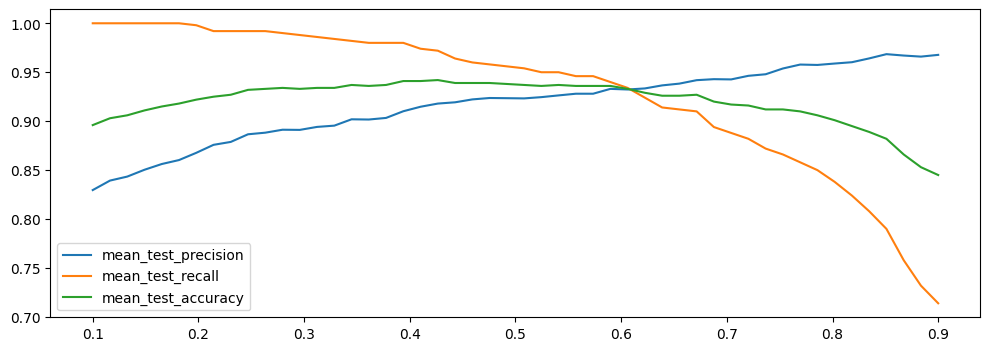

In [55]:
plt.figure(figsize=(12, 4))
df_results = pd.DataFrame(mod.cv_results_)
for score in ['mean_test_precision', 'mean_test_recall', 'mean_test_accuracy']:
    plt.plot([_ for _ in df_results['param_model__threshold']], 
             df_results[score], 
             label=score)
plt.legend();

### Grouped Models

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklego.datasets import load_chicken
from sklego.preprocessing import ColumnSelector

df = load_chicken(as_frame=True)

def plot_model(model):
    df = load_chicken(as_frame=True)
    model.fit(df[['diet', 'time']], df['weight'])
    metric_df = df[['diet', 'time', 'weight']].assign(pred=lambda d: model.predict(d[['diet', 'time']]))
    metric = mean_absolute_error(metric_df['weight'], metric_df['pred'])
    plt.figure(figsize=(12, 4))
    # plt.scatter(df['time'], df['weight'])
    for i in [1, 2, 3, 4]:
        pltr = metric_df[['time', 'diet', 'pred']].drop_duplicates().loc[lambda d: d['diet'] == i]
        plt.plot(pltr['time'], pltr['pred'], color='.rbgy'[i])
    plt.title(f"linear model per group, MAE: {np.round(metric, 2)}");

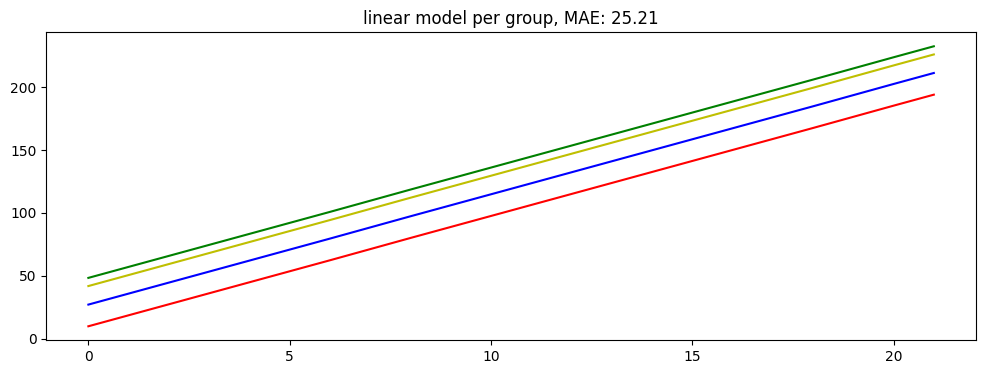

In [59]:
feature_pipeline = Pipeline([
    ("datagrab", FeatureUnion([
        ("discrete", Pipeline([
            ("grab", ColumnSelector("diet")),
            ("encode", OneHotEncoder(categories="auto", sparse_output=False))
        ])),
        ("continuous", Pipeline([
            ("grab", ColumnSelector("time")),
            ("stadardize", StandardScaler())
        ]))
    ]))
])

pipe = Pipeline([
    ("tranform", feature_pipeline),
    ("model", LinearRegression())
])

plot_model(pipe)

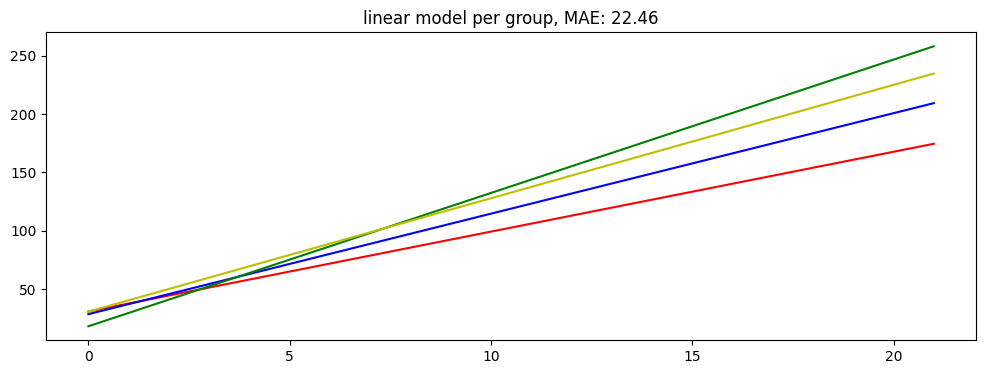

In [60]:
from sklego.meta import GroupedPredictor
mod = GroupedPredictor(LinearRegression(), groups=["diet"])
plot_model(mod)

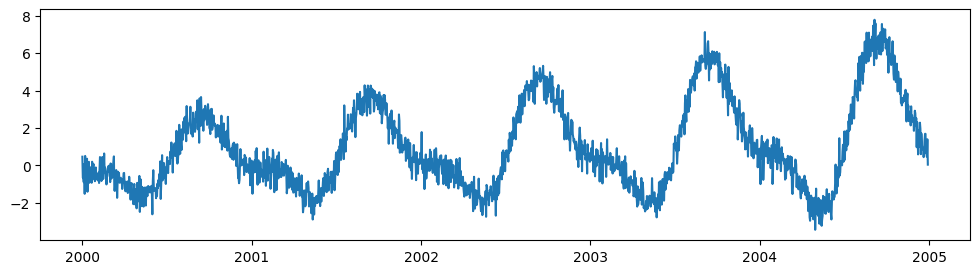

In [61]:
from sklego.meta import GroupedPredictor, DecayEstimator
from sklego.datasets import make_simpleseries

yt = make_simpleseries(seed=1)
dates = pd.date_range("2000-01-01", periods=len(yt))

df = (
    pd.DataFrame({"yt": yt, "date": dates})
    .assign(m=lambda d: d.date.dt.month)
    .reset_index()
)

plt.figure(figsize=(12, 3))
plt.plot(dates, make_simpleseries(seed=1))

In [74]:
_ = DecayEstimator(DummyRegressor())
?_

Type:        DecayEstimator
String form: DecayEstimator(model=DummyRegressor())
File:        e:\projects\web\python\python_jupiter_test\.venv\lib\site-packages\sklego\meta\decay_estimator.py
Docstring:  
Morphs an estimator such that the training weights can be adapted to ensure that points that are far away have
less weight.

This meta estimator will only work for estimators that allow a `sample_weights` argument in their `.fit()` method.
The meta estimator `.fit()` method computes the weights to pass to the estimator's `.fit()` method.

!!! warning
    It is up to the user to sort the dataset appropriately.

!!! warning
    By default all the checks on the inputs `X` and `y` are delegated to the wrapped estimator.
    To change such behaviour, set `check_input` to `True`.
    Remark that if the check is skipped, then `y` should have a `shape` attribute, which is
    used to extract the number of samples in training data, and compute the weights.

Parameters
----------
model : scikit-

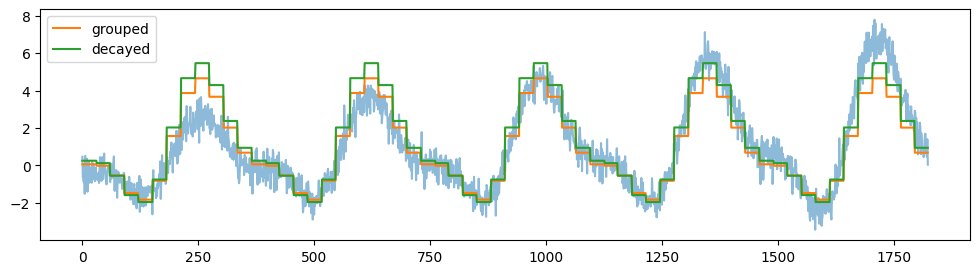

In [90]:
from sklearn.dummy import DummyRegressor

mod1 = (GroupedPredictor(DummyRegressor(), groups=["m"])
  .fit(df[['m']], df['yt']))

mod2 = (GroupedPredictor(DecayEstimator(DummyRegressor(), decay_func="linear"), groups=["m"])
        .fit(df[['index', 'm']], df['yt']))

plt.figure(figsize=(12, 3))
plt.plot(df['yt'], alpha=0.5);
plt.plot(mod1.predict(df[['m']]), label="grouped")
plt.plot(mod2.predict(df[['index', 'm']]), label="decayed")
plt.legend();